# ML Case  Study

### Goals

   - Code churn
      - Convert trips in last 30 to date time (Done)
      - booleanify (Done)
   - Dummify cities (Done)
   - Dummify phone type (Done)
   - Determine which columns are likely to be predictive
       - lmplots conditioned on churn
       - categorical means by churn 
         - Clearly phone and city are important for churn rate
           - significantly so?
           - Why?
   - Handle class imbalance
       - 62% churn - likely not important
   
### Model building

Define goals: Prediction or interpretation
 
 - Choose model type

     - Has feature importance 
       - Random forest
     - interpretable coefficients?
       - logistic regression
  - Create different models by city or by phone type
    - Try to understand why there are such big differences in the cities and phones
     

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [302]:

df = pd.read_csv('data/churn.csv')


# Data Cleaning

In [303]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)

# Add churn column
df['days_since_last_trip'] = (df.last_trip_date.max() - df.last_trip_date) / np.timedelta64(1, 'D')
df['churn'] = (df['days_since_last_trip'] > 30)

# Days since signup
df.signup_date = pd.to_datetime(df.signup_date)
df['days_since_signup'] = (df.last_trip_date.max() - df.signup_date) / np.timedelta64(1, 'D')

In [304]:
df.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,churn,days_since_signup
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,False,157
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,True,153
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,True,176
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,False,172
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,True,155


# Plots Conditioned by Churn

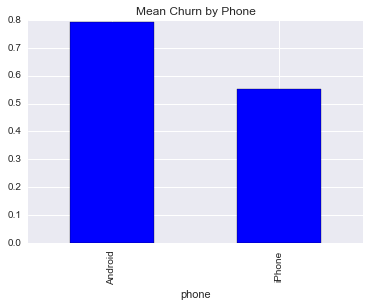

In [305]:
df['phone'] = np.where(df.phone.isnull(), "iPhone", df.phone)
df.groupby('phone').churn.mean().plot(kind="bar")
plt.title("Mean Churn by Phone");

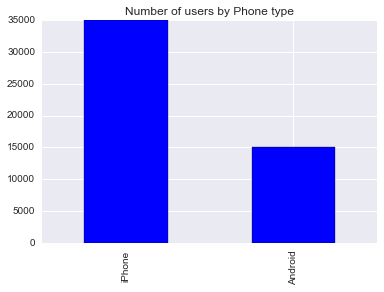

In [271]:
df['phone'].value_counts().plot(kind="bar")
plt.title("Number of users by Phone type")

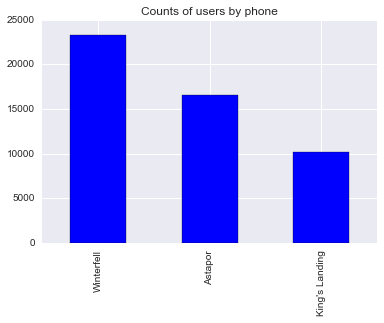

In [272]:
df['city'].value_counts().plot(kind="bar")
plt.title("Counts of users by phone");


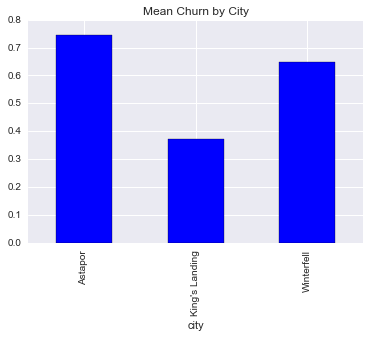

In [273]:
df.groupby('city').churn.mean().plot(kind="bar")
plt.title("Mean Churn by City");

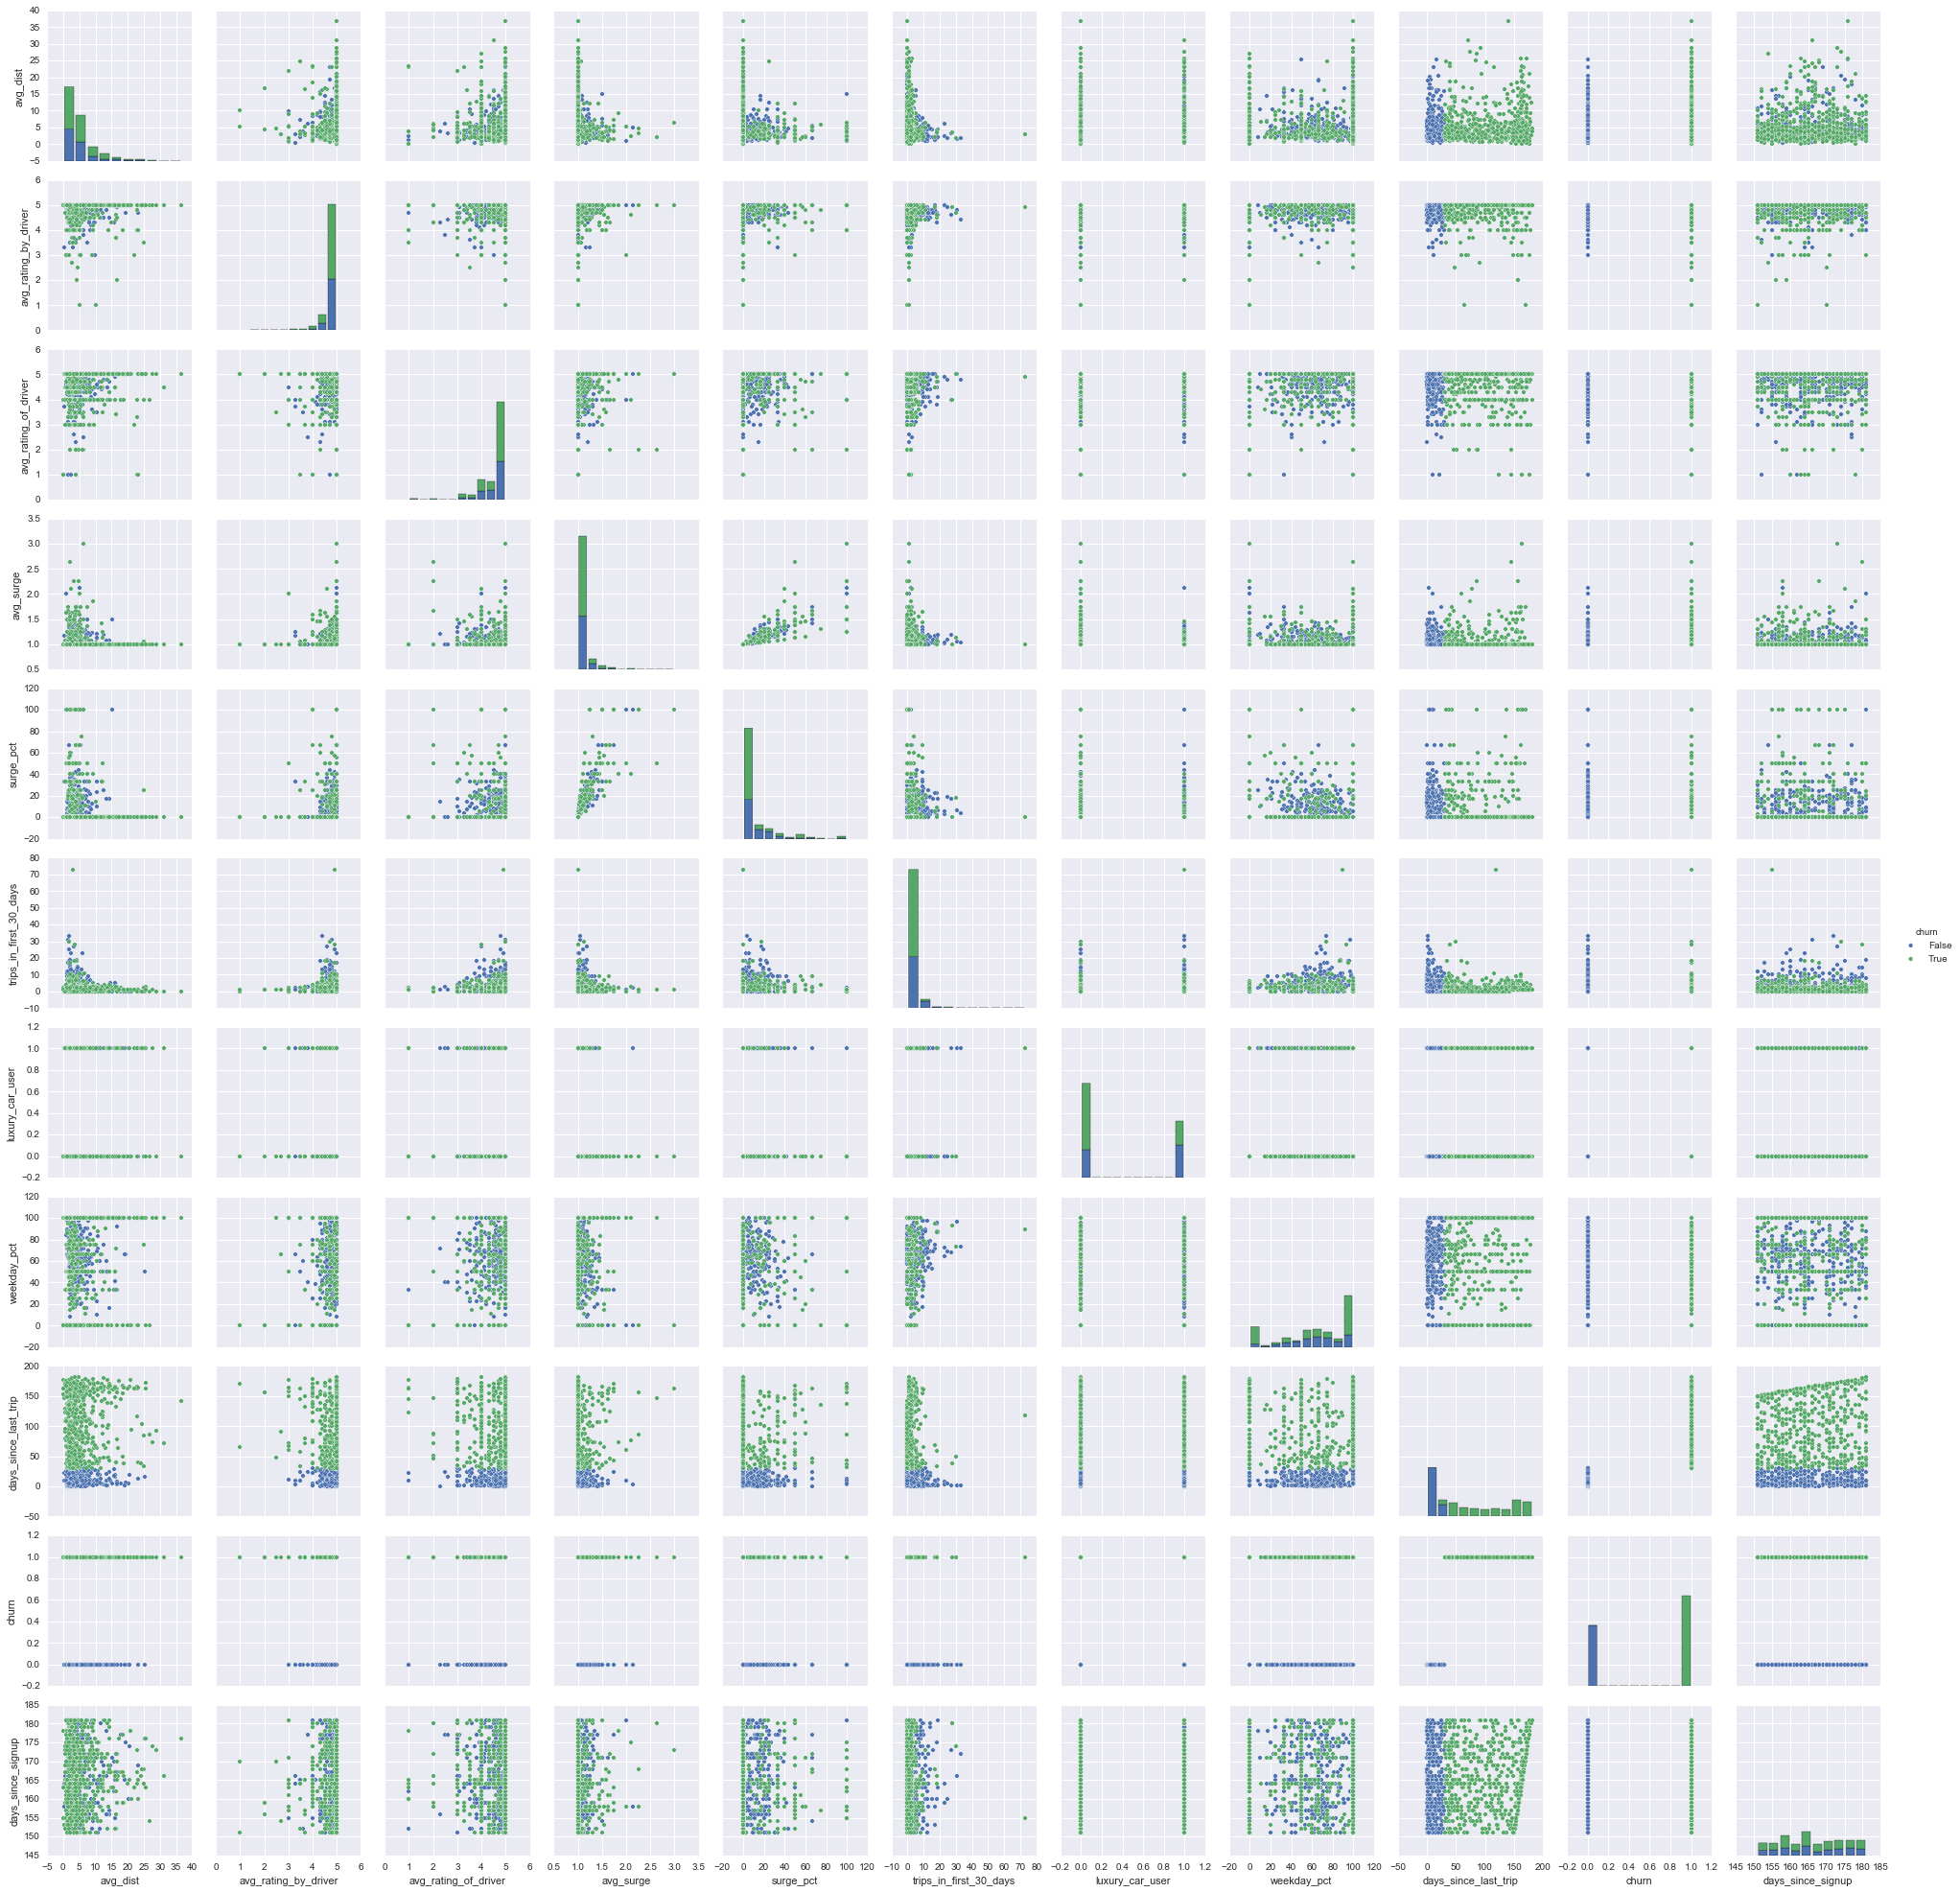

In [185]:
sns.pairplot(df.dropna().sample(1000)[[col for col in df.columns if col not in ['city', 'phone']]], hue="churn")

# Dummyifying Variables


In [274]:
df['isAndroid'] = np.where(df['phone'] == "Android", True, False)
df.drop('phone', axis=1, inplace=True)

df_city = pd.get_dummies(df['city'])
frames = [df, df_city]
df = pd.concat(frames, axis=1)
df = df.drop('city', axis=1)

In [275]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,churn,days_since_signup,isAndroid,Astapor,King's Landing,Winterfell
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,14,False,157,False,0,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,57,True,153,True,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,175,True,176,False,1,0,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,2,False,172,False,0,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,108,True,155,True,0,0,1


# Investigating Average Surge effect on Churn

In [276]:
df.groupby('churn').avg_surge.describe()

churn       
False  count    18804.000000
       mean         1.073809
       std          0.163170
       min          1.000000
       25%          1.000000
       50%          1.000000
       75%          1.090000
       max          4.500000
True   count    31196.000000
       mean         1.075339
       std          0.251361
       min          1.000000
       25%          1.000000
       50%          1.000000
       75%          1.000000
       max          8.000000
dtype: float64

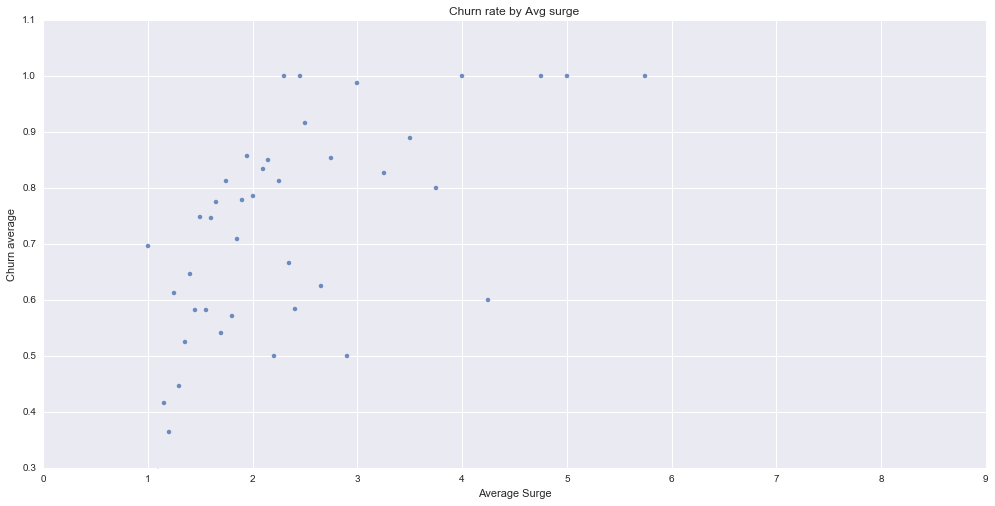

In [277]:
epsilon = 0.025
avg_churn = []
avg_surge = []
num_obs = []
for avg in np.arange(1,8,epsilon*2):
    
    avg_churn.append(df[(df.avg_surge < avg + epsilon) & (df.avg_surge > avg - epsilon)].churn.mean())
    num_obs.append(df[(df.avg_surge < avg + epsilon) & (df.avg_surge > avg - epsilon)].shape[0])
    avg_surge.append(avg)

ch_vs_surge = pd.DataFrame(zip(avg_surge, avg_churn, num_obs)).rename(columns={0:"avg_surge", 1:"avg_churn", 2:'num_obs'})

sns.lmplot(x='avg_surge', y='avg_churn', data=ch_vs_surge, fit_reg=False, size=7, aspect=2)
plt.title("Churn rate by Avg surge")
plt.xlabel("Average Surge")
plt.ylabel("Churn average")
plt.ylim(0.3,1.1);

# Pairwise t-tests for categoricals

In [278]:
from scipy.stats import ttest_ind
t_tests = {'Android-iPhone':"(statistic=56.177771317354384, pvalue=0.0)","Astapor-King's Landing":"(statistic=63.338256512763827, pvalue=0.0)",
         'Astapor-Winterfell':"(statistic=20.857565532357761, pvalue=4.5904054869968492e-96)",
          "King's Landing-Winterfell":"(statistic=-48.199064350367962, pvalue=0.0)",
          'luxury-not luxury':"(statistic=-45.830427267725014, pvalue=0.0)"}
t_tests

{'Android-iPhone': '(statistic=56.177771317354384, pvalue=0.0)',
 "Astapor-King's Landing": '(statistic=63.338256512763827, pvalue=0.0)',
 'Astapor-Winterfell': '(statistic=20.857565532357761, pvalue=4.5904054869968492e-96)',
 "King's Landing-Winterfell": '(statistic=-48.199064350367962, pvalue=0.0)',
 'luxury-not luxury': '(statistic=-45.830427267725014, pvalue=0.0)'}

# Logistic Regression

In [279]:
y = df['churn']
col=['avg_dist', 'avg_surge', 'surge_pct', 'Astapor', "King's Landing", "Winterfell",
      'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct',
      'isAndroid', 'days_since_signup']
X = df[col]

X.head()

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()

0.71636012296720486

In [299]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LogisticRegression()
model.fit(X_train, y_train)

logit_coefs = pd.DataFrame(zip(X.columns, np.transpose(model.coef_).squeeze())).\
    rename(columns = {0:'Variable', 1:'LogOdds'})
    
logit_coefs['OddsRatio'] = np.exp(logit_coefs.LogOdds)

logit_coefs.sort_values('OddsRatio', ascending=False)


,Variable,LogOdds,OddsRatio
9,isAndroid,1.105126,3.019604
3,Astapor,0.824825,2.281482
1,avg_surge,0.391731,1.479540
5,Winterfell,0.296711,1.345426
0,avg_dist,0.036982,1.037674
8,weekday_pct,0.000277,1.000277
10,days_since_signup,-0.001501,0.998500
2,surge_pct,-0.005242,0.994772
6,trips_in_first_30_days,-0.118424,0.888320
4,King's Landing,-0.853155,0.426069


## Insights:

Android users have 3 times the odds of churning than do iPhone users, all other things held constant

# Random Forest

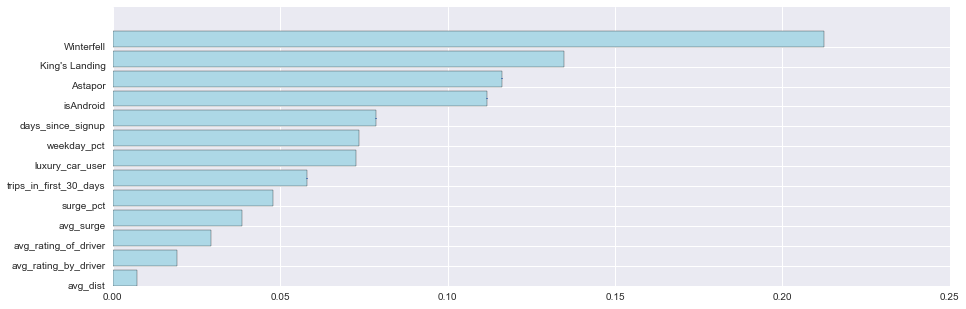

In [281]:
from sklearn.ensemble import RandomForestClassifier
df_xgb = df.drop(['signup_date', 'last_trip_date', 'days_since_last_trip'], axis=1).copy()
y = df_xgb.pop('churn').values

df_xgb.avg_rating_by_driver = df_xgb.avg_rating_by_driver.fillna(df_xgb.avg_rating_by_driver.mean())
df_xgb.avg_rating_of_driver = df_xgb.avg_rating_of_driver.fillna(df_xgb.avg_rating_of_driver.mean())
X = df_xgb.values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=8, test_size=.2)
rf = RandomForestClassifier().fit(X_train, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
            axis=0)
indices = np.argsort(importances)
plt.figure(figsize=(15,5))
plt.barh(range(len(indices)), importances[indices], yerr=std[indices], color='lightblue')
ticks = plt.yticks(range(len(indices)), df_xgb.columns)


# XGBoost

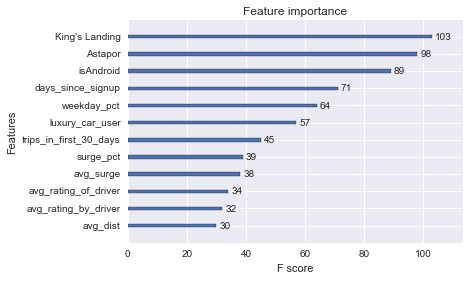

In [282]:
import xgboost
gbm = xgboost.XGBClassifier(silent=False, seed=8).fit(X_train, y_train)
plot = xgboost.plot_importance(gbm)
ticks = plot.set_yticklabels(df_xgb.columns)


In [291]:
df_xgb['churn']=y

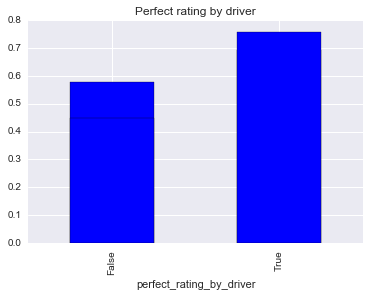

In [292]:

df_xgb['perfect_rating_of_driver'] = (df_xgb.avg_rating_of_driver == 5)
df_xgb.groupby('perfect_rating_of_driver').mean().churn.plot(kind='bar')
plt.title('Perfect rating of driver')

df_xgb['perfect_rating_by_driver'] = (df_xgb.avg_rating_by_driver == 5)
df_xgb.groupby('perfect_rating_by_driver').mean().churn.plot(kind='bar')
plt.title('Perfect rating by driver')

# Gradient Boosting

In [283]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print gbc.score(X_test, y_test)
gb_imp = pd.DataFrame(zip(X.columns, np.transpose(gbc.feature_importances_)))
gb_imp

0.7796


,0,1
0,avg_dist,0.117730
1,avg_surge,0.092883
2,surge_pct,0.051060
3,Astapor,0.041959
4,King's Landing,0.132563
5,Winterfell,0.112665
6,trips_in_first_30_days,0.066523
7,luxury_car_user,0.170222
8,weekday_pct,0.029253
9,isAndroid,0.067410


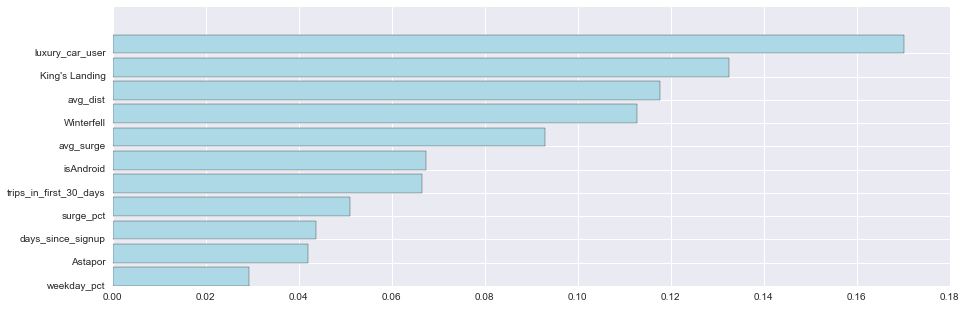

In [284]:
gb_imp.sort_values(1, ascending=True, inplace=True)
plt.figure(figsize=(15,5))
plt.barh(range(gb_imp.shape[0]), gb_imp[1], color='lightblue')
ticks = plt.yticks(range(gb_imp.shape[0]), gb_imp[0])